In [1]:
import MySQLdb as mariadb
from astropy.table import vstack, Table, Column
from astropy.time import Time
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
import argparse
from reportlab.pdfgen.canvas import Canvas
from datetime import datetime, timedelta
from pprint import pprint
import re
import os

In [2]:
def extractStationData(station_code, database_name, mjd_start, mjd_stop, search='%', like_or_notlike=0):
    if float(like_or_notlike) == 1:
        like = "NOT LIKE"
    else:
        like = "LIKE"
    
    conn = mariadb.connect(user='auscope', passwd='password')
    cursor = conn.cursor()
    query = "USE " + database_name +";"
    cursor.execute(query)
    query = "SELECT ExpID, Date, Date_MJD, Performance, Performance_UsedVsRecov, session_fit, W_RMS_del, Detect_Rate_X, Detect_Rate_S, Total_Obs, Notes, Pos_X, Pos_Y, Pos_Z, Pos_E, Pos_N, Pos_U FROM " + station_code+ " WHERE ExpID " + like + " \"" + search + "\" AND Date_MJD > " + str(mjd_start) + " AND Date_MJD < " + str(mjd_stop) + " ORDER BY DATE ASC;"
    cursor.execute(query)
    result = cursor.fetchall()
    col_names = ["ExpID", "Date", "Date_MJD", "Performance", "Performance_UsedVsRecov", "session_fit", "W_RMS_del", "Detect_Rate_X", "Detect_Rate_S", "Total_Obs", "Notes", "Pos_X", "Pos_Y", "Pos_Z", "Pos_E", "Pos_N", "Pos_U"]
    
    return result, col_names 


In [3]:
def grabStations(sqldb_name):
    conn = mariadb.connect(user='auscope', passwd='password')
    cursor = conn.cursor()
    query1 = "USE " + sqldb_name +";"
    cursor.execute(query1)
    query2 = "SHOW TABLES;"
    cursor.execute(query2)
    result = cursor.fetchall()

    return result

In [4]:
stat_list = grabStations('auscopeDB')

In [5]:
reverse_search = 1
search = 'v%'
stat_code = 'Hb'
db_name = 'auscopeDB'

start_time = Time('2024:001', format='yday', out_subfmt='date')
stop_time = Time('2025:050', format='yday', out_subfmt='date')

vgos = None

if search == 'v%' and reverse_search == 0:
    vgos = True
elif search == 'v%' and reverse_search == 1:
    vgos = False

In [6]:
def grabAllStationData(stat_list, db_name, start_time, stop_time, search, reverse_search):
    table_list = []
    stat_in_tab_list = []
    for code in stat_list:
        result, col_names = extractStationData(code[0], db_name, start_time.mjd, stop_time.mjd, search, reverse_search)
        if len(result) > 0:
            table = Table(rows=result, names=col_names)
            table_list.append(table)
            stat_in_tab_list.append(code[0])

    return stat_in_tab_list, table_list

In [7]:
stat_tab_list, table_list = grabAllStationData(stat_list, db_name, start_time, stop_time, search, reverse_search)

In [8]:
def sumTotalObs(table_list, stat_tab_list):
    temp_table_list = table_list.copy() 
    col_name = 'Total_Obs'

    # Filter out None values
    for i in range(0, len(temp_table_list)):
        bad_data = []
        for j in range(0, len(temp_table_list[i][col_name])):
            if temp_table_list[i][col_name][j] == None:
                bad_data.append(j)

        temp_table_list[i].remove_rows(bad_data)
    
    # Sum the total obs for all sessions in the table
    sum_obs_list = []
    for i in range(0, len(temp_table_list)):
        sum_obs_list.append([stat_tab_list[i], np.sum(temp_table_list[i][col_name])])

    sum_obs_list = np.array(sum_obs_list)

    sorted_indices = sum_obs_list[:, 1].argsort()[::-1]
    sum_obs_list = sum_obs_list[sorted_indices]

    return sum_obs_list

In [9]:
sum_obs_list = sumTotalObs(table_list, stat_tab_list)

In [10]:
def medWRMSdel(table_list, stat_tab_list):
    temp_table_list = table_list.copy() 
    col_name = 'W_RMS_del'

    # Filter out None values
    for i in range(0, len(temp_table_list)):
        bad_data = []
        for j in range(0, len(temp_table_list[i][col_name])):
            if temp_table_list[i][col_name][j] == -999 or temp_table_list[i][col_name][j] == None:
                bad_data.append(j)

        temp_table_list[i].remove_rows(bad_data)

    # Sum the total obs for all sessions in the table
    med_wrms_list = []
    for i in range(0, len(temp_table_list)):
        med_wrms_list.append([stat_tab_list[i], np.median(temp_table_list[i][col_name])])

    med_wrms_list = np.array(med_wrms_list)

    sorted_indices = med_wrms_list[:, 1].argsort()
    med_wrms_list = med_wrms_list[sorted_indices]

    return med_wrms_list

In [11]:
med_wrms_list = medWRMSdel(table_list, stat_tab_list)

In [12]:
def numSessions(table_list, stat_tab_list):
    temp_table_list = table_list.copy() 
    col_name = 'Total_Obs'

    # Filter out None values
    for i in range(0, len(temp_table_list)):
        bad_data = []
        for j in range(0, len(temp_table_list[i][col_name])):
            if temp_table_list[i][col_name][j] == 0 or temp_table_list[i][col_name][j] == None:
                bad_data.append(j)

        temp_table_list[i].remove_rows(bad_data)

    # Sum the total sessions (with >0 observations) for all sessions in the table
    data_list = []
    for i in range(0, len(temp_table_list)):
        data_list.append([stat_tab_list[i], len(temp_table_list[i][col_name])])

    data_list = np.array(data_list)

    sorted_indices = data_list[:, 1].astype(float).argsort()[::-1]
    data_list = data_list[sorted_indices]

    return data_list

In [13]:
num_sess_list = numSessions(table_list, stat_tab_list)

Text(0, 0.5, 'Sum of observations')

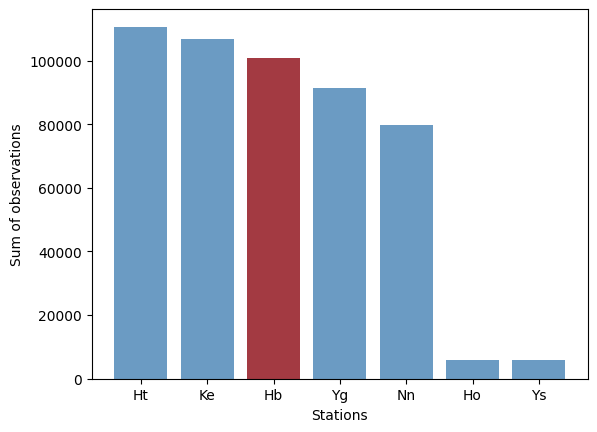

In [39]:
# Total Obs bar plot

specific_stat = np.where(sum_obs_list[:,0] == 'Hb')[0]

fig, ax = plt.subplots()

bars = ax.bar(sum_obs_list[0:10,0], sum_obs_list[0:10,1], color='steelblue', alpha=0.8) # Plot the 10 best performing stations
bar_specific =  ax.bar(sum_obs_list[specific_stat,0], sum_obs_list[specific_stat,1], color='firebrick', alpha=0.8) # Plot the 'target' station

#ax.bar_label(bars, label_type='edge')

plt.xlabel('Stations')
plt.ylabel('Sum of observations')

Text(0, 0.5, 'Number of sessions')

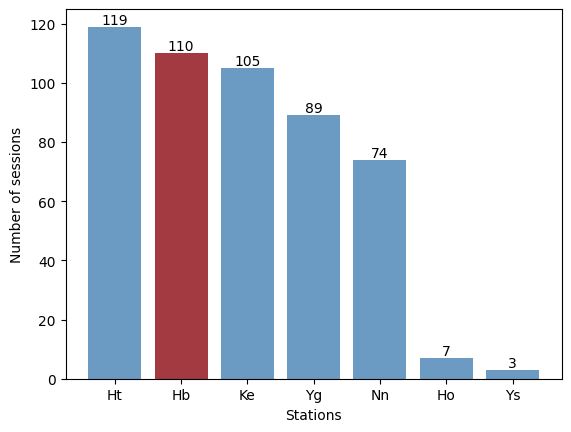

In [37]:
# Number of sessions in time period

specific_stat = np.where(num_sess_list[:,0] == 'Hb')[0]

fig, ax = plt.subplots()

bars = ax.bar(num_sess_list[0:10,0], num_sess_list[0:10,1].astype(float), color='steelblue', alpha=0.8) # Plot the 10 best performing stations
bar_specific =  ax.bar(num_sess_list[specific_stat,0], num_sess_list[specific_stat,1].astype(float), color='firebrick', alpha=0.8) # Plot the 'target' station

ax.bar_label(bars, label_type='edge')

plt.xlabel('Stations')
plt.ylabel('Number of sessions')

Text(0, 0.5, 'Median station fit (ps)')

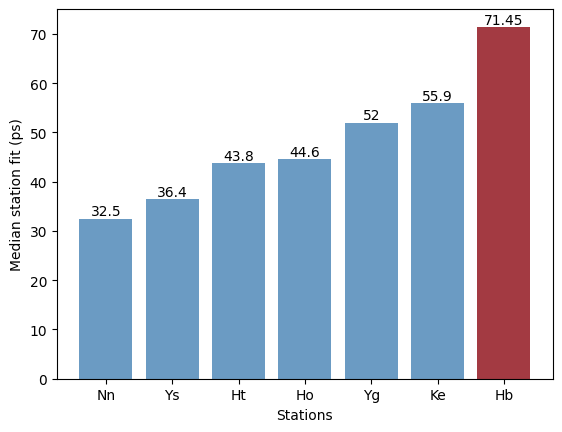

In [40]:
# Median W_RMS del bar plot

specific_stat = np.where(med_wrms_list[:,0] == 'Hb')[0]

fig, ax = plt.subplots()

bars = ax.bar(med_wrms_list[0:10,0], med_wrms_list[0:10,1], color='steelblue', alpha=0.8) # Plot the 10 best performing stations
bar_specific =  ax.bar(med_wrms_list[specific_stat,0], med_wrms_list[specific_stat,1], color='firebrick', alpha=0.8) # Plot the 'target' station

ax.bar_label(bars, label_type='edge')

plt.xlabel('Stations')
plt.ylabel('Median station fit (ps)')